### Relation Networks

Although neural networks like CNNs and MLPs are powerful in a variety of tasks, they struggle with relational reasoning. Relation network is a neural network module designed for relational reasoning tasks. It constrains the functional form of NN to avoid overfitting to specific features of the objects and thus provides a generalized network module that can be plugged in to a vareity of tasks.

Relation Networks (RN) can be simply represented by equation below, where $O$ is a set of objects, denoted as $O = \{o_1, o_2, ..., o_n\}$. Meanwhile, $f_{\phi}$ and $g_{\theta}$ are MLPs with learnable and differentiable parameters $\phi$ and $\theta$.

$$RN(O) = f_{\phi} \Big( \sum_{i, j} g_{\theta} (o_i, o_j)\Big)$$


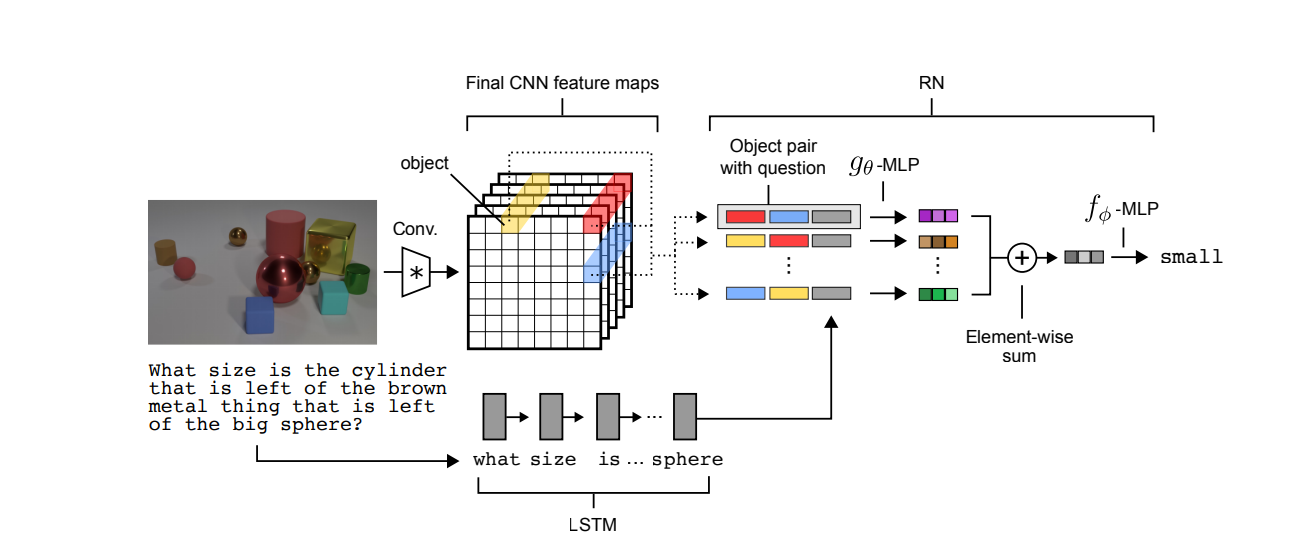

#### Dealing with pixels (CNN)

For visual question answering tasks (VQA), the images are processed with a convolutional neural network (CNN). For example, an image of dimension $75 \times 75 \times 3$ are processed using the four-layer CNN module below. Each of the four layers use a kernel of dimension $3 \times 3$, stride $2$ and padding $1$. The number of kernels are $32, 64, 128$ and $256$, respectively. After the covolutional operations in each layer, ReLU activation was applied, along with batch normalization. The dimensinon of 75 in the original image becomes 5, as calculated by the sequences below.
\begin{align*}
    \frac{1}{2} \times (75 - 3 + 2 \times 1) + 1 &= 38 \\
    \frac{1}{2} \times (38 - 3 + 2 \times 1) + 1 &= 19 \\
    \frac{1}{2} \times (19 - 3 + 2 \times 1) + 1 &= 10 \\
    \frac{1}{2} \times (10 - 3 + 2 \times 1) + 1 &= 5
\end{align*}

```python
class CNNModel(nn.Module):
    def __init__(self):
        super(CNNModel, self).__init__()        
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, stride=2, padding=1)
        self.batchNorm1 = nn.BatchNorm2d(32)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=2, padding=1)
        self.batchNorm2 = nn.BatchNorm2d(64)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, stride=2, padding=1)
        self.batchNorm3 = nn.BatchNorm2d(128)
        self.conv4 = nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3, stride=2, padding=1)
        self.batchNorm4 = nn.BatchNorm2d(256)
        
    def forward(self, image):
        x = self.conv1(image)
        x = F.relu(x)
        x = self.batchNorm1(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = self.batchNorm2(x)
        x = self.conv3(x)
        x = F.relu(x)
        x = self.batchNorm3(x)
        x = self.conv4(x)
        x = F.relu(x)
        x = self.batchNorm4(x)
        return x
```

The output dimension of the CNN model is $5 \times 5 \times 256$, where $k = 256$ is the number of channels and $d = 5$ is the dimension of the resulting feature map. As discussed in Section 4 of the paper ("Dealing with pixels"), the 'object' is a generalized concept. Specifically, the feature map consists of dimension cells of size $k = 256$, and each of the $d^2 = 25$ such cells is treated as an object. It is up to the downstream neural networks to learn how to reason about each object. Thus, we do not only input the embedding of the objects in the images, but everything in the feature map is considered as an 'object'.

#### Plug-in relational module (MLPs)

In this section, we discuss how to deal with the object pairs (functions $f_{\phi}$ and $g_{\theta}$). As given in the supplementary material of the paper (Section D). For the Sort-of-Clevr model, $g_{\theta}$ is a four-layer MLP consisting of 2000 hidden nodes per layer with ReLU actiation function; while $f_{\theta}$ is a four-layer MLP consisting of 2000, 1000, 500 and 100 hidden nodes with ReLU activation function. The output will be further processed by another linear layer to calculate logits for the softmax over all possible answers. For this dataset, we consider 10 classes ('no', 'yes', 'rectangle', 'circle', '1', '2', '3', '4', '5', '6'). Thus, it is a 10-way classification problem.

```python
class gTheta(nn.Module):
    def __init__(self):
        super(gTheta, self).__init__()
        self.g_fc1 = nn.Linear((256 + 2) * 2 + 11, 2000)
        self.g_fc2 = nn.Linear(2000, 2000)
        self.g_fc3 = nn.Linear(2000, 2000)
        self.g_fc4 = nn.Linear(2000, 2000)

    def forward(self, x):
        x = F.relu(self.g_fc1(x))
        x = F.relu(self.g_fc2(x))
        x = F.relu(self.g_fc3(x))
        x = F.relu(self.g_fc4(x))
        return x

class fPhi(nn.Module):
    def __init__(self):
        super(fPhi, self).__init__()
        self.f_fc1 = nn.Linear(2000, 2000)
        self.f_fc2 = nn.Linear(2000, 1000)
        self.f_fc3 = nn.Linear(1000, 500)
        self.f_fc4 = nn.Linear(500, 100)

    def forward(self, x):
        x = F.relu(self.f_fc1(x))
        x = F.relu(self.f_fc2(x))
        x = F.relu(self.f_fc3(x))
        x = F.relu(self.f_fc4(x))
        return x
```

#### Putting things together

In this section, we assemble the network following the figure above. First, we get the spatial information about each 'object' (256-dimensional embedding). The resulting 2-dimensional coordinates are concatenated to the embedding to give a 258 dimensional embedding. Further, we pair all the embeddings and add question embeddings. Here in this problem, question embeddings are treated as one-hot vectors, rather than using LSTM. Because we have 25 objects in each feature map, and thus the number of object pairs is $25 \times 25 = 625$. For each pair, the dimension is $(256 + 2) \times 2 + 11 = 527$, which includes a 11-dimensional question encoding, and two objects embeddings each with 256 pixel features and 2 coordinate information. These info are processed by the $g$ function and the element-wise summation of the result will be further processed by the $f$ function before the final output layer.

```python
def get_coordinates(batch_size):
    np_coordinates = np.zeros((batch_size, 25, 2))
    for i in range(25):
        np_coordinates[:,i,:] = np.array([i // 5, i % 5]) / 2 - 1
    return torch.FloatTensor(np_coordinates)

class RN(nn.Module):
    def __init__(self):
        super(RN, self).__init__()
        self.conv = CNNModel()
        self.f_phi = fPhi()
        self.g_theta = gTheta()
        self.output_layer = nn.Linear(100, 10)

    def forward(self, image, questions):
        x = self.conv(image)                                 # dim: (batch_size x 256 x 5 x 5)
        batch_size, channels, feat_size, _ = x.size()

        x = x.view(batch_size, channels, feat_size ** 2).permute(0, 2, 1) # dim: (batch_size x 25 x 256)
        
        # find positions to the feature maps
        sptial_positions = get_coordinates(batch_size)

        # add spatial coordinates to the last dimension of the input
        x = torch.cat([x, sptial_positions], 2)               # dim: (batch_size x 25 x (256 + 2))

        # combine all object pairs with questions
        object_1 = torch.unsqueeze(x, 1)                      # dim: (batch_size x 1 x 25 x 258)
        object_1 = object_1.repeat(1, 25, 1, 1)               # dim: (batch_size x 25 x 25 x 258)
        object_2 = torch.unsqueeze(x, 2)                      # dim: (batch_size x 25 x 1 x 258)
        object_2 = object_2.repeat(1, 1, 25, 1)               # dim: (batch_size x 25 x 25 x 258)
        
        # combine questions with each pair of objects
        questions = torch.unsqueeze(questions, 1)             # dim: (batch_size x 1 x 11)
        questions = questions.repeat(1, 25, 1)                # dim: (batch_size x 25 x 11)
        questions = torch.unsqueeze(questions, 2)             # dim: (batch_size x 25 x 1 x 11)
        questions = questions.repeat(1, 1, 25, 1)             # dim: (batch_size x 25 x 25 x 11)
        
        # concatenate all together
        x = torch.cat([object_1, object_2, questions], 3)     # dim: (batch_size x 25 x 25 x (258 x 2 + 11))
        
        # reshape for passing through network
        x = x.view(batch_size * feat_size ** 4, -1)
        x = self.g_theta(x)
        
        # element-wise sum
        x = x.view(batch_size, feat_size ** 4, 2000)
        x = x.sum(1).squeeze()

        x = self.f_phi(x)
        x = F.relu(self.output_layer(x))
        return F.log_softmax(x, dim=1)
```

### Test performance

The figure below shows the accuracy on the test data when training the model on 20 epochs. We found that the non-relational questions are easier to learn, because after 10 epochs the accuracy already reaches over 99%, while the relational questions are harder. At the last epoch, the relational accuracy is 90.48%, although it may constinue to improve as we train longer. 

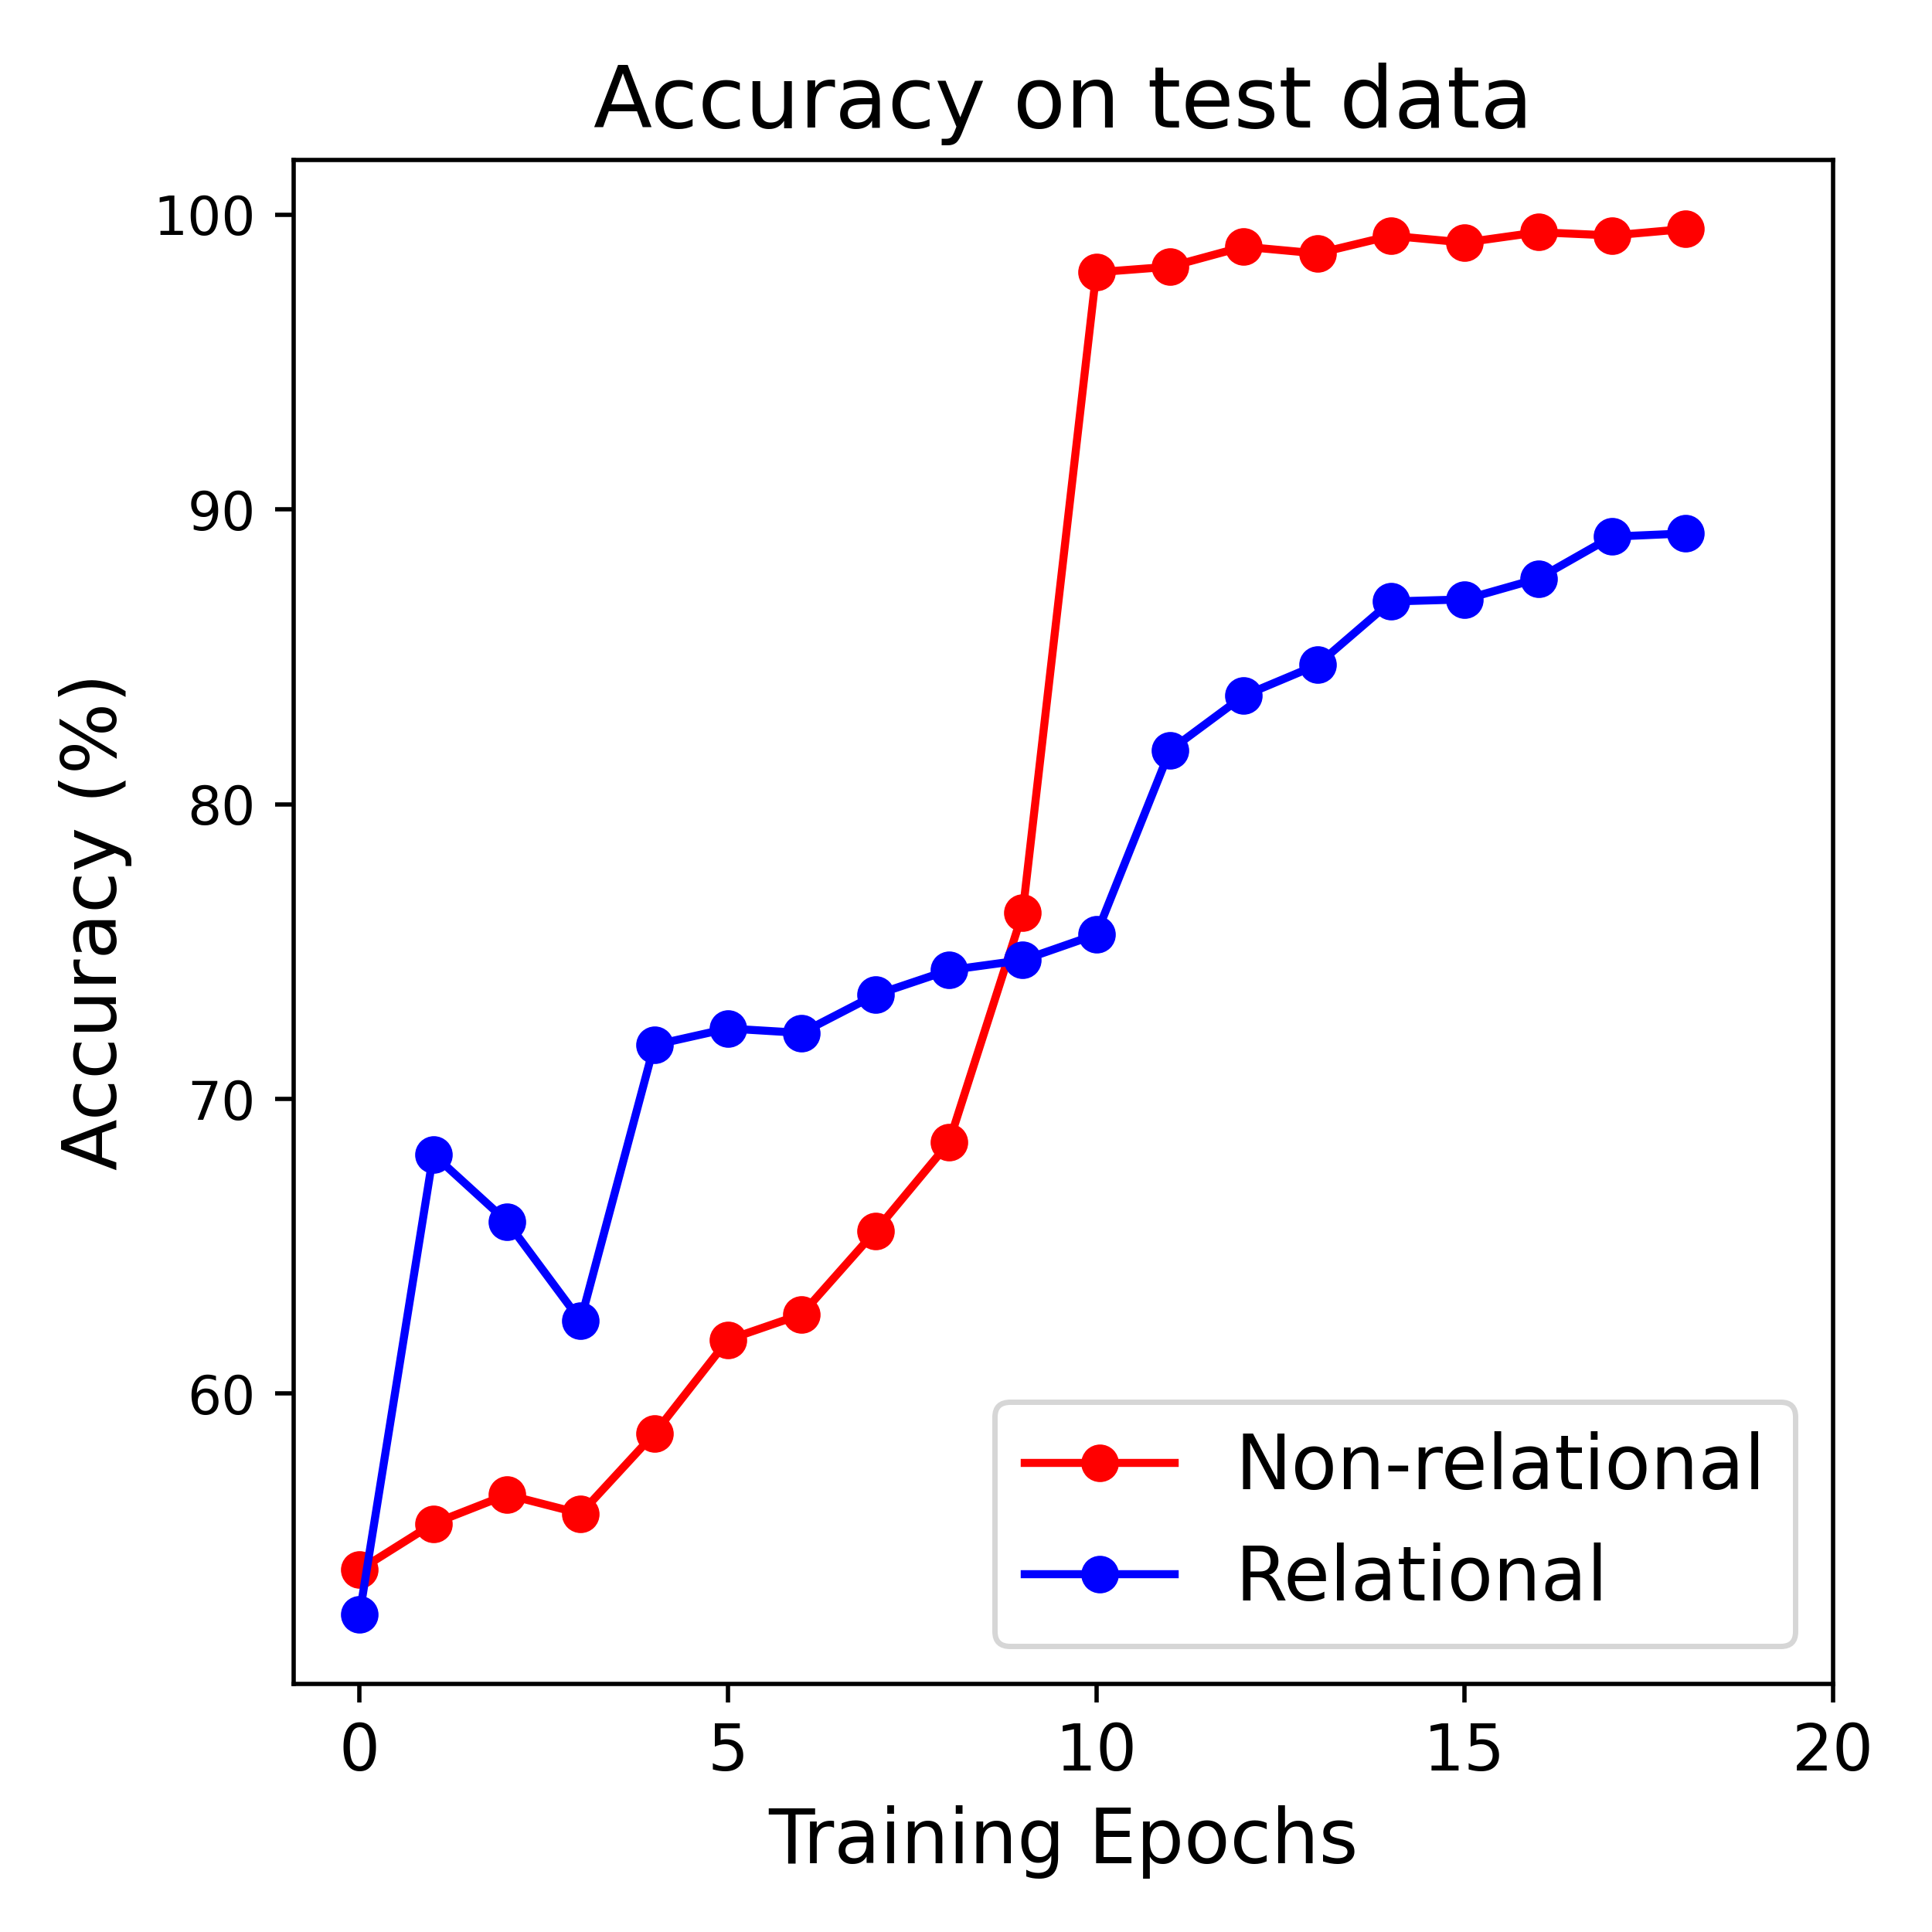